In [1]:
import networkx as nx
import numpy as np
import itertools as it
import random
import time
import scipy
from matplotlib import pyplot as plt
import fresnel

In [2]:
np.random.seed(100)
random.seed(100)

In [3]:
def coordination_pattern(x):
    """
    To do: obtain the neighbors of an input atom position
    Args:
        x: the position of atoms
    Returns:
        the neighbors of the atoms, excluding the center atoms
    """
    return np.array([x+np.array([0.5,0.5,0]),
                     x+np.array([-0.5,0.5,0]),
                     x+np.array([0.5,-0.5,0]),
                     x+np.array([-0.5,-0.5,0]),
                     x+np.array([0.5,0,0.5]),
                     x+np.array([0.5,0,-0.5]),
                     x+np.array([-0.5,0,0.5]),
                     x+np.array([-0.5,0,-0.5]),
                     x+np.array([0,0.5,0.5]),
                     x+np.array([0,-0.5,0.5]),
                     x+np.array([0,0.5,-0.5]),
                     x+np.array([0,-0.5,-0.5]),
                    ])
def neighbors(x):
    """
    To do: obtain the occupied sites for a given cell
    Args:
        x: the position of cells
    Returns:
        the occupied sites in the cells
    """
    #define sites of fcc cell where x is the body center
    return np.array([x+np.array([0.5,0,0]),
                     x+np.array([-0.5,0,0]),
                     x+np.array([0,-0.5,0]),
                     x+np.array([0,0.5,0]),
                     x+np.array([0,0,0.5]),
                     x+np.array([0,0,-0.5]),      
                     x+np.array([0.5,0.5,0.5]),
                     x+np.array([-0.5,-0.5,0.5]),
                     x+np.array([0.5,-0.5,0.5]),
                     x+np.array([-0.5,0.5,0.5]),           
                     x+np.array([0.5,0.5,-0.5]),
                     x+np.array([-0.5,-0.5,-0.5]),
                     x+np.array([0.5,-0.5,-0.5]),
                     x+np.array([-0.5,0.5,-0.5])   
                    ])
    

In [4]:
position = []
for x in range(-100,100):
    for y in range(-100,100):
        for z in range(-100,100):
            if abs(x)+abs(y)+abs(z)<=16:
                position.append([x,y,z])
position = np.array(position)
print(len(position))
position = np.array(neighbors(position).flatten().reshape(-1,3))
position = np.unique(position,axis=0)
print(len(position))
position = position.tolist()

dipole_position = []
for x in range(-20,20):
    for y in range(-20,20):
        for z in range(-20,20):
            dipole_position.append([x,y,z])
dipole_position = np.array(dipole_position)

6017
27438


In [5]:
# calculate how many atoms exist in individual dipoles
dipole_position_neighbor = neighbors(dipole_position)
atom_num = []
for index in range(dipole_position_neighbor.shape[1]):
    dipole_position_neighbor_tmp = dipole_position_neighbor[:,index].tolist()
    atom_num.append(sum([(i in position) for i in dipole_position_neighbor_tmp]))

# create a hashable dictionary for individual diples
atom_num_dic = {}
for i in range(len(dipole_position)):
    atom_num_dic[tuple(dipole_position[i].tolist())] = atom_num[i]

In [6]:
# initialie the change number
dipole_change_count = []

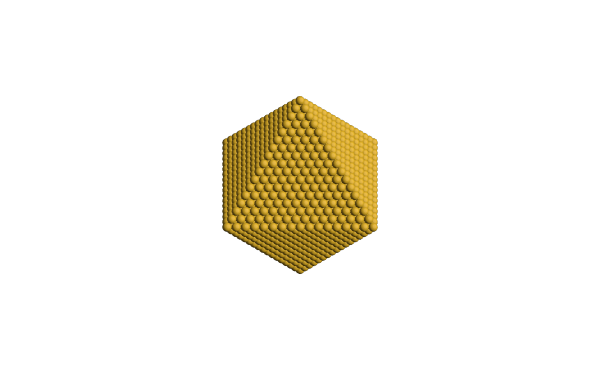

In [7]:
selected_dipoles = np.array(list(atom_num_dic.values())) == 14
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(dipole_position[selected_dipoles]), radius=np.sqrt(2)/2)
geometry.position[:] = dipole_position[selected_dipoles]
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

In [8]:
for step in range(1,20092):
    # read in the temporary steps 
    atoms_changes_type = np.loadtxt(f'./data2/atoms_changes_type{step*100}.csv',delimiter=',')
    atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
    count = 0 
    for change_type in atoms_changes_type:
        same_time_dipole_change_number = 0
        if change_type ==3:
            pass
        # addition event
        elif change_type ==1:
            # get the atoms to be added
            x = atoms_changes[count]
            # check if it is in the surface or at the corner
            index = np.where(np.around(x) != x)[0]
            # if at the surface
            if len(index) == 1:
                i = index[0]
                
                # get the top cell
                x_tmp = x.copy() # 1
                x_tmp[i] = x_tmp[i]+0.5
                atom_num_dic[tuple(x_tmp.tolist())] = atom_num_dic[tuple(x_tmp.tolist())] + 1

                # check if the dipoles are fully occupied now
                if atom_num_dic[tuple(x_tmp.tolist())] == 14:
                    dipole_change_count.append(np.concatenate((x_tmp,np.array([1]))))
                    same_time_dipole_change_number = same_time_dipole_change_number + 1
                    
                # get the bottom cell
                x_tmp = x.copy() #2
                x_tmp[i] = x_tmp[i]-0.5
                atom_num_dic[tuple(x_tmp.tolist())] = atom_num_dic[tuple(x_tmp.tolist())] + 1
                
                # check if the dipoles are fully occupied now
                if atom_num_dic[tuple(x_tmp.tolist())] == 14:
                    dipole_change_count.append(np.concatenate((x_tmp,np.array([1]))))
                    same_time_dipole_change_number = same_time_dipole_change_number + 1
            # if at the corner
            elif len(index)==3:
                x_temp = neighbors(x)
                for i in x_temp[-8:]:
                    atom_num_dic[tuple(i.tolist())] = atom_num_dic[tuple(i.tolist())] + 1
                    # check if the dipoles are fully occupied now
                    if atom_num_dic[tuple(i.tolist())] == 14:
                        dipole_change_count.append(np.concatenate((i,np.array([1]))))
                        same_time_dipole_change_number = same_time_dipole_change_number + 1
            else:
                pass
            
            # change the count number
            position.append(x.tolist())
            count = count +1
        # deletion event
        else:
            # get the atoms to be deleted
            x = atoms_changes[count]
            # check if it is in the surface or at the corner
            index = np.where(np.around(x) != x)[0]
            # if at the surface
            if len(index) == 1:
                i = index[0]
                # get the top cell
                x_tmp = x.copy()
                x_tmp[i] = x_tmp[i]+0.5
                atom_num_dic[tuple(x_tmp.tolist())] = atom_num_dic[tuple(x_tmp.tolist())] - 1
                
                # check if the dipoles are fully occupied now
                if atom_num_dic[tuple(x_tmp.tolist())] == 13:
                    dipole_change_count.append(np.concatenate((x_tmp,np.array([0]))))
                    same_time_dipole_change_number = same_time_dipole_change_number + 1
                    
                # get the bottom cell
                x_tmp = x.copy()
                x_tmp[i] = x_tmp[i]-0.5
                atom_num_dic[tuple(x_tmp.tolist())] = atom_num_dic[tuple(x_tmp.tolist())] - 1
                
                # check if the dipoles are fully occupied now
                if atom_num_dic[tuple(x_tmp.tolist())] == 13:
                    dipole_change_count.append(np.concatenate((x_tmp,np.array([0]))))
                    same_time_dipole_change_number = same_time_dipole_change_number + 1
            # if at the corner
            elif len(index)==3:
                x_temp = neighbors(x)
                for i in x_temp[-8:]:
                    atom_num_dic[tuple(i.tolist())] = atom_num_dic[tuple(i.tolist())] - 1
                    # check if the dipoles are fully occupied now
                    if atom_num_dic[tuple(i.tolist())] == 13:
                        dipole_change_count.append(np.concatenate((i,np.array([0]))))
                        same_time_dipole_change_number = same_time_dipole_change_number + 1
            else:
                pass            
            
            position.remove(x.tolist())
            count = count +1
        if same_time_dipole_change_number > 1:
            dipole_change_count_temp = dipole_change_count[-same_time_dipole_change_number:].copy()
            np.random.shuffle(dipole_change_count_temp)
            dipole_change_count[-same_time_dipole_change_number:] = dipole_change_count_temp

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes17100.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes17600.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes18100.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes18300.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes18600.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_ch

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes44600.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes44700.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes45000.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes45100.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes45200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_ch

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes79700.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes79800.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes79900.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes80100.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes80200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_ch

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes113700.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes113800.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes113900.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes114100.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes114500.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes150200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes150300.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes151400.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes151700.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes151800.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes183400.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes183500.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes183700.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes184200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes184300.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes215100.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes215600.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes215800.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes215900.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes216100.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes245200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes245400.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes246000.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes246100.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes246200.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes274500.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes274700.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes274800.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes275000.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes275400.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes302500.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes302700.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes302900.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes303600.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes303700.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes328200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes328600.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes329000.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes329400.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes329500.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes353900.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes354300.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes354600.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes354700.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes354900.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes379800.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes380400.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes381600.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes382100.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes382600.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes405000.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes407200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes408600.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes408800.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes410200.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes429800.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes430000.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes430100.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes430500.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes430700.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes454900.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes455300.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes455400.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes455500.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes456000.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes478200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes478500.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes478600.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes478700.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes478900.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes523900.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes524200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes524800.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes525400.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes525600.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes569100.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes569200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes570300.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes572200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes574000.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes617300.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes618800.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes619300.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes621700.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes623600.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes682300.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes686000.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes687800.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes690800.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes695100.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes768100.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes768200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes772900.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes774200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes775200.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes874900.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes877200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes877300.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes879700.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes883300.csv"
  atoms_changes =  np.loadtxt(f'./data2/ato

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes995700.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes997100.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes1016600.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes1018000.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes1030200.csv"
  atoms_changes =  np.loadtxt(f'./data2/

/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes1460900.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes1469000.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes1475000.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes1475200.csv"
  atoms_changes =  np.loadtxt(f'./data2/atoms_changes{step*100}.csv',delimiter=',').reshape(-1,3)
/tmp/ipykernel_3598842/998904468.py:4: UserWarning: loadtxt: Empty input file: "./data2/atoms_changes1483100.csv"
  atoms_changes =  np.loadtxt(f'./data

# Validate the atomic coordination number

In [9]:
# calculate how many atoms exist in individual dipoles
atom_num2 = []
for index in range(dipole_position_neighbor.shape[1]):
    dipole_position_neighbor_tmp = dipole_position_neighbor[:,index].tolist()
    atom_num2.append(sum([(i in position) for i in dipole_position_neighbor_tmp]))

# create a hashable dictionary for individual diples
atom_num_dic2 = {}
for i in range(len(dipole_position)):
    atom_num_dic2[tuple(dipole_position[i])] = atom_num2[i]

In [10]:
abs(np.array(list(atom_num_dic2.values())) - np.array(list(atom_num_dic.values()))).max()

0

# Show structures

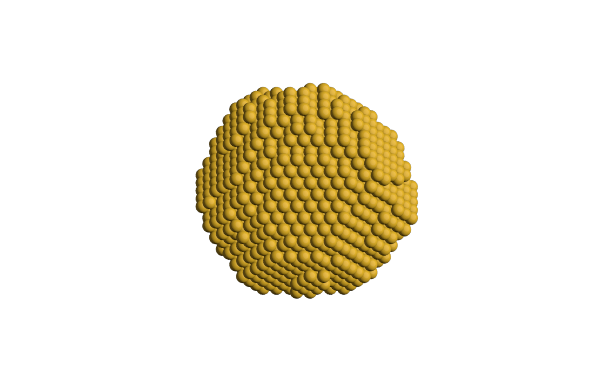

In [11]:
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(position), radius=np.sqrt(2)/4)
geometry.position[:] = position
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

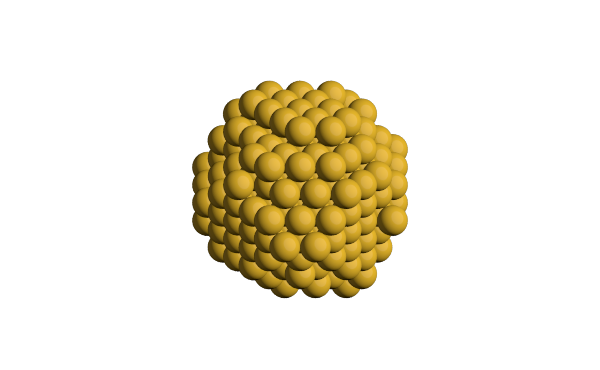

In [12]:
selected_dipoles = np.array(list(atom_num_dic.values())) == 14
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(dipole_position[selected_dipoles]), radius=np.sqrt(2)/2)
geometry.position[:] = dipole_position[selected_dipoles]
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

In [13]:
# Generate the trajecotry according to the dipole change which is recorded above
dipole_position = dipole_position.tolist()
dipole_change_count = np.array(dipole_change_count)
changed_dipole_index = [dipole_position.index(dipole_change_count[i][0:3].tolist()) for i in range(len(dipole_change_count))]

In [14]:
# get the initial dipole position
position = []
for x in range(-100,100):
    for y in range(-100,100):
        for z in range(-100,100):
            if abs(x)+abs(y)+abs(z)<=16:
                position.append([x,y,z])
position = np.array(position)
initial_dipole_index = [dipole_position.index(position[i].tolist()) for i in range(len(position))]

In [15]:
# check if all the changed dipoles are contained in the initial dipole configuration
# if so, we will just use the original dipole configuration to set up the system
print(sum([i in initial_dipole_index for i in np.unique(changed_dipole_index)]))
print(len(np.unique(changed_dipole_index)))

5599
5599


In [16]:
# get the changed dipole index with respect to the new dipole configuration
position = position.tolist()
changed_dipole_index = [position.index(dipole_change_count[i][0:3].tolist()) for i in range(len(dipole_change_count))]
changed_dipole_index = np.array(changed_dipole_index)
changed_dipole_type = dipole_change_count[:,3]

In [17]:
Au_dipoles = np.ones(len(position),dtype = bool)
for i in range(len(changed_dipole_index)):
    if changed_dipole_type[i] == 1:
        Au_dipoles[changed_dipole_index[i]] = True
    else:
        Au_dipoles[changed_dipole_index[i]] = False

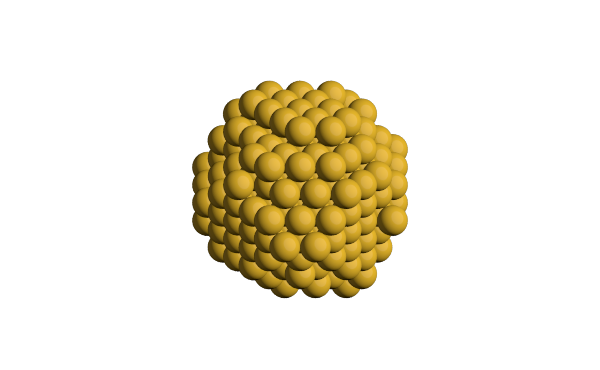

In [18]:
scene = fresnel.Scene()
geometry = fresnel.geometry.Sphere(scene, N=len(np.array(position)[Au_dipoles]), radius=np.sqrt(2)/2)
geometry.position[:] = np.array(position)[Au_dipoles]
geometry.material = fresnel.material.Material(color=fresnel.color.linear([0.9, 0.714, 0.169]), roughness = 0.2)
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

In [19]:
np.savetxt('./data2/changed_dipole_index.csv',changed_dipole_index,delimiter=',')
np.savetxt('./data2/changed_dipole_type.csv',changed_dipole_type,delimiter=',')